In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import numpy as np

############################ Load and Clean Datasets ##########################################

In [3]:
# Load datasets
metadata_path = 'na_metadata.csv'
weather_path = 'na_weather.csv'
electricity_path = 'updated_transposed_daily_electricity_usage.csv'

In [4]:
metadata_df = pd.read_csv(metadata_path)
weather_df = pd.read_csv(weather_path)
electricity_df = pd.read_csv(electricity_path)

In [5]:
# Drop unnecessary columns from metadata
columns_to_drop_metadata = [
    'building_id_kaggle', 'site_id_kaggle', 'solar', 'industry', 'subindustry',
    'heatingtype', 'date_opened', 'numberoffloors', 'occupants', 'energystarscore',
    'eui', 'site_eui', 'source_eui', 'leed_level', 'rating'
]
metadata_df_cleaned = metadata_df.drop(columns=columns_to_drop_metadata, errors='ignore')

In [6]:
# Convert weather timestamp to datetime
weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'], format='%d-%m-%Y %H:%M')

In [7]:
# Reshape electricity usage dataset into long format
electricity_long = electricity_df.melt(
    id_vars=['building_name', 'site_id'],
    var_name='date',
    value_name='electricity_usage'
)
electricity_long['date'] = pd.to_datetime(electricity_long['date'], format='%d-%m-%Y')

In [8]:
# Merge electricity usage with metadata and weather data
electricity_metadata_merged = electricity_long.merge(
    metadata_df_cleaned,
    left_on=['building_name', 'site_id'],
    right_on=['building_id', 'site_id'],
    how='left'
)
final_merged_dataset = electricity_metadata_merged.merge(
    weather_df,
    left_on=['site_id', 'date'],
    right_on=['site_id', 'timestamp'],
    how='left'
)
final_merged_dataset.drop(columns=['timestamp'], inplace=True)

In [9]:
# Drop irrelevant columns
columns_to_drop_final = [
    'hotwater', 'chilledwater', 'steam', 'water', 'irrigation', 'gas', 'unique_space_usages'
]
final_merged_dataset_cleaned = final_merged_dataset.drop(columns=columns_to_drop_final, errors='ignore')

###################### Feature Engineering ####################################################

In [10]:
# Add time-based features
final_merged_dataset_cleaned['month'] = final_merged_dataset_cleaned['date'].dt.month
final_merged_dataset_cleaned['day_of_week'] = final_merged_dataset_cleaned['date'].dt.dayofweek
final_merged_dataset_cleaned['is_weekend'] = final_merged_dataset_cleaned['day_of_week'].isin([5, 6]).astype(int)

In [11]:
# Add lag features
final_merged_dataset_cleaned['lag_1'] = final_merged_dataset_cleaned['electricity_usage'].shift(1)
final_merged_dataset_cleaned['lag_7'] = final_merged_dataset_cleaned['electricity_usage'].shift(7)
final_merged_dataset_cleaned.dropna(subset=['lag_1', 'lag_7'], inplace=True)

################# Visualizing Building Electricity Usage Trends ##################################################

In [12]:
# Aggregate electricity usage over time (daily trends across all buildings)
aggregated_data = final_merged_dataset_cleaned.groupby('date')['electricity_usage'].sum().reset_index()

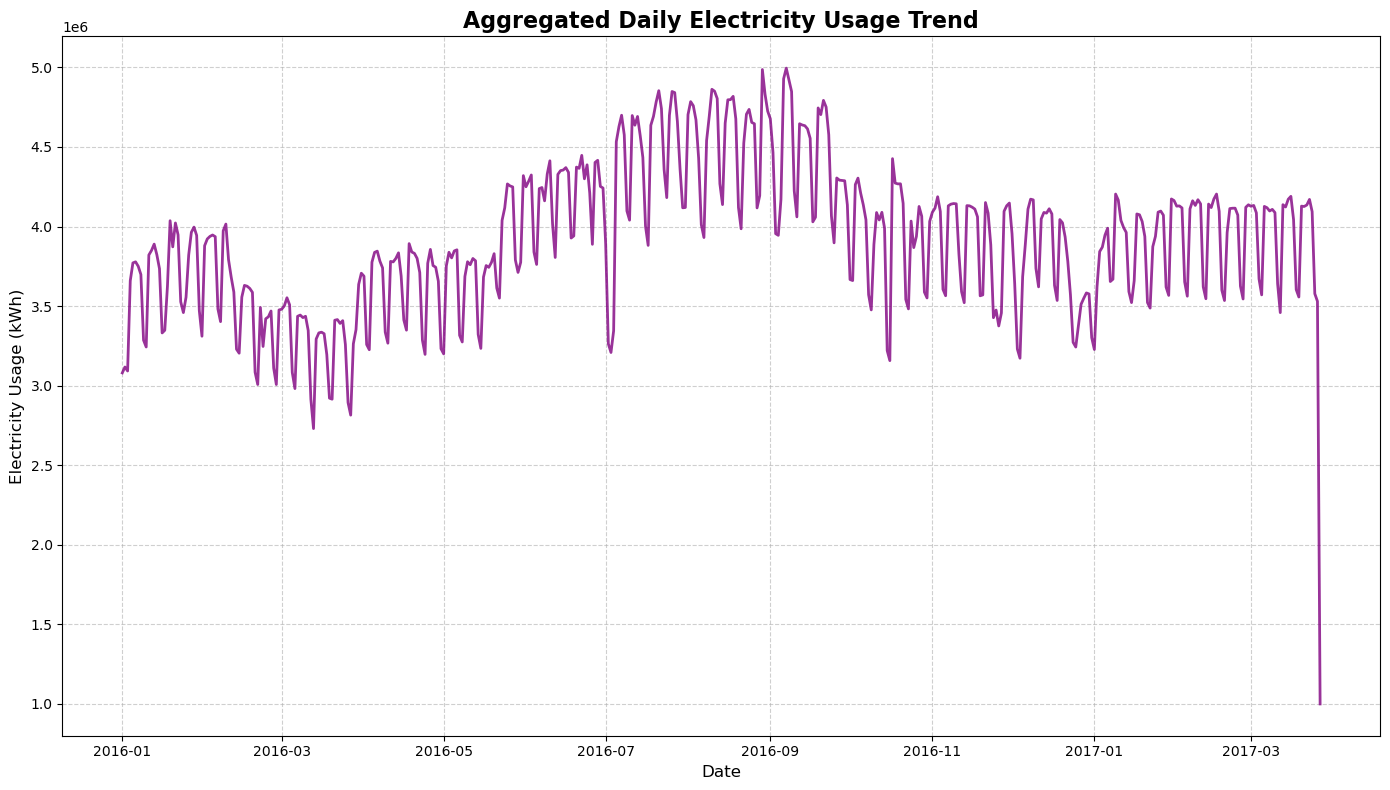

In [13]:
# Plot the aggregated electricity usage trend
plt.figure(figsize=(14, 8))
plt.plot(aggregated_data['date'], aggregated_data['electricity_usage'], color='purple', linewidth=2, alpha=0.8)
plt.title('Aggregated Daily Electricity Usage Trend', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Electricity Usage (kWh)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [14]:
# Select a sample of buildings to visualize electricity usage trends
sample_buildings = final_merged_dataset_cleaned['building_name'].dropna().unique()[:5]  # Adjust the number as needed

In [15]:
# Filter data for these buildings
sample_data = final_merged_dataset_cleaned[final_merged_dataset_cleaned['building_name'].isin(sample_buildings)]

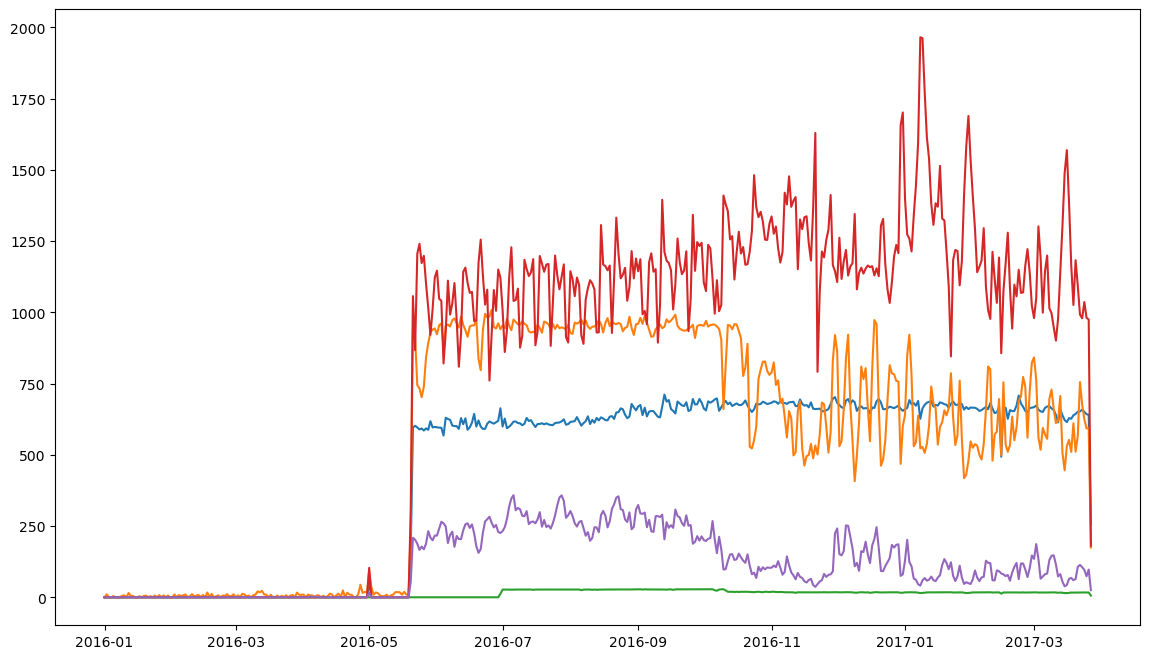

In [16]:
# Plot electricity usage trends for each building
plt.figure(figsize=(14, 8))
for building in sample_buildings:
    building_data = sample_data[sample_data['building_name'] == building]
    plt.plot(
        building_data['date'], 
        building_data['electricity_usage'], 
        label=building
    )

/var/folders/rz/m9y4lv2543b4h866w76_dhv40000gn/T/ipykernel_92553/2682707025.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Building Name", fontsize=10)


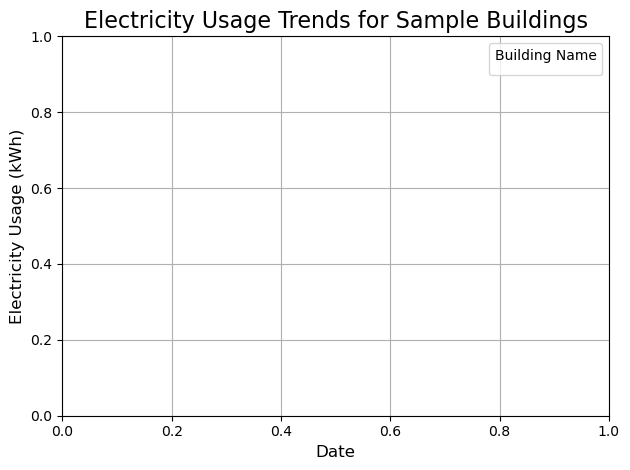

In [17]:
plt.title('Electricity Usage Trends for Sample Buildings', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Electricity Usage (kWh)', fontsize=12)
plt.legend(title="Building Name", fontsize=10)
plt.grid(True)
plt.tight_layout()

In [18]:
# Show the plot
plt.show()

############################## Outlier Removal #######################################################

In [19]:
# Detect and remove outliers using IQR
Q1 = final_merged_dataset_cleaned['electricity_usage'].quantile(0.25)
Q3 = final_merged_dataset_cleaned['electricity_usage'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [20]:
final_merged_dataset_cleaned = final_merged_dataset_cleaned[
    (final_merged_dataset_cleaned['electricity_usage'] >= lower_bound) &
    (final_merged_dataset_cleaned['electricity_usage'] <= upper_bound)
]

######################### Handle Missing Values #################################################

In [21]:
# Impute missing values for predictors
predictors = [
    'month', 'day_of_week', 'is_weekend', 'airTemperature',
    'dewTemperature', 'seaLvlPressure', 'windSpeed', 'sqm', 'lag_1', 'lag_7'
]

In [22]:
final_merged_dataset_cleaned[predictors].isnull().sum()

month                 0
day_of_week           0
is_weekend            0
airTemperature     3985
dewTemperature     4193
seaLvlPressure    10655
windSpeed          4503
sqm                   0
lag_1                 0
lag_7                 0
dtype: int64

In [23]:
# Fill missing values with 0 for the predictors
final_merged_dataset_cleaned[predictors] = final_merged_dataset_cleaned[predictors].fillna(0)

############################ Random Forest Regression ##############################################

In [24]:
# Train-test split
X = final_merged_dataset_cleaned[predictors]
y = final_merged_dataset_cleaned['electricity_usage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train) #Time Taken: Approx 10 mins

RandomForestRegressor(random_state=42)

In [26]:
# Predict and evaluate
y_pred = rf_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

/opt/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [27]:
print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2}")
print(f"Mean Absolute Error: {mae}")
# Output 
# Root Mean Squared Error: 386.3929068829207
# R^2 Score: 0.9610776214968123
# Mean Absolute Error: 167.09625589991595

Root Mean Squared Error: 386.6993214351472
R^2 Score: 0.9610158651247058
Mean Absolute Error: 167.02139702154778


In [28]:
# Feature Importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

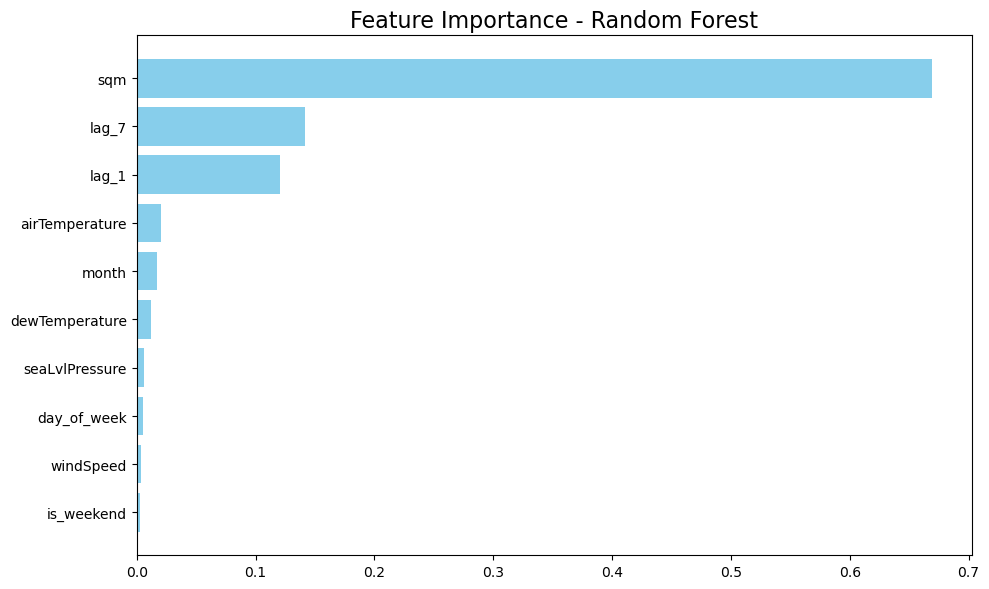

In [29]:
# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Feature Importance - Random Forest', fontsize=16)
plt.tight_layout()
plt.show()

########################## Cross Validation #################################################

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [31]:
# Perform k-fold cross-validation on the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [32]:
# Use negative mean squared error for scoring
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_squared_error')
# Time Taken: Between 30-45 mins 

In [33]:
# Convert scores to positive RMSE
rmse_scores = np.sqrt(-cv_scores)

In [34]:
print("Cross-Validation Results:")
print(f"RMSE for each fold: {rmse_scores}")
print(f"Mean RMSE: {rmse_scores.mean()}")
print(f"Standard Deviation of RMSE: {rmse_scores.std()}")

Cross-Validation Results:
RMSE for each fold: [808.3012438  605.49004787 619.33343765 589.20341117 878.96991661]
Mean RMSE: 700.2596114195294
Standard Deviation of RMSE: 119.5609994109185


OUTPUT
Cross-Validation Results:
RMSE for each fold: [806.21498444 607.50697149 620.53994971 590.9044764  879.38227603]
Mean RMSE: 700.9097316140258
Standard Deviation of RMSE: 118.51259763968248

In [35]:
# Evaluate overall model performance using cross-validation
mean_rmse = rmse_scores.mean()
std_rmse = rmse_scores.std()

In [36]:
print(f"Cross-Validated RMSE: {mean_rmse:.2f} ± {std_rmse:.2f}")
# OUTPUT
# Cross-Validated RMSE: 700.91 ± 118.51

Cross-Validated RMSE: 700.26 ± 119.56


############################ Visualization ##############################################3

In [37]:
# Plot a subset of the data
size = 500  # Adjust the number of points to display
# Apply rolling mean for smoothing
rolling_window = 50
y_test_rolling = y_test.reset_index(drop=True).rolling(window=rolling_window).mean()
y_pred_rolling = pd.Series(y_pred).rolling(window=rolling_window).mean()

In [38]:
plt.figure(figsize=(16, 12))

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

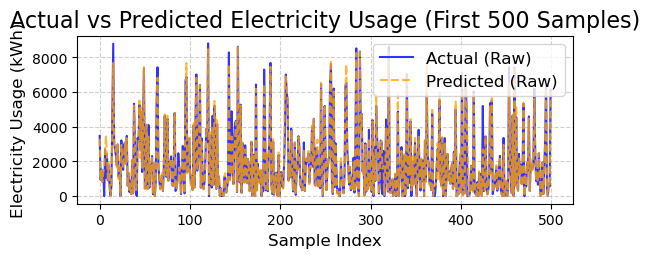

In [39]:
# Subplot 1: Actual vs Predicted (Raw)
plt.subplot(2, 1, 1)
plt.plot(y_test.reset_index(drop=True)[:size], label='Actual (Raw)', color='blue', linewidth=1.5, alpha=0.8)
plt.plot(y_pred[:size], label='Predicted (Raw)', color='orange', linestyle='--', linewidth=1.5, alpha=0.8)
plt.title(f'Actual vs Predicted Electricity Usage (First {size} Samples)', fontsize=16)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Electricity Usage (kWh)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

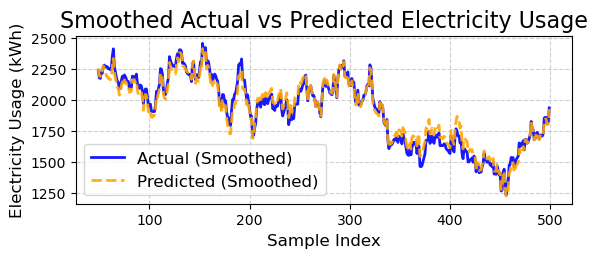

In [40]:
# Subplot 2: Smoothed Actual vs Predicted
plt.subplot(2, 1, 2)
plt.plot(y_test_rolling[:size], label='Actual (Smoothed)', color='blue', linewidth=2, alpha=0.9)
plt.plot(y_pred_rolling[:size], label='Predicted (Smoothed)', color='orange', linestyle='--', linewidth=2, alpha=0.9)
plt.title('Smoothed Actual vs Predicted Electricity Usage', fontsize=16)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Electricity Usage (kWh)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

In [41]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

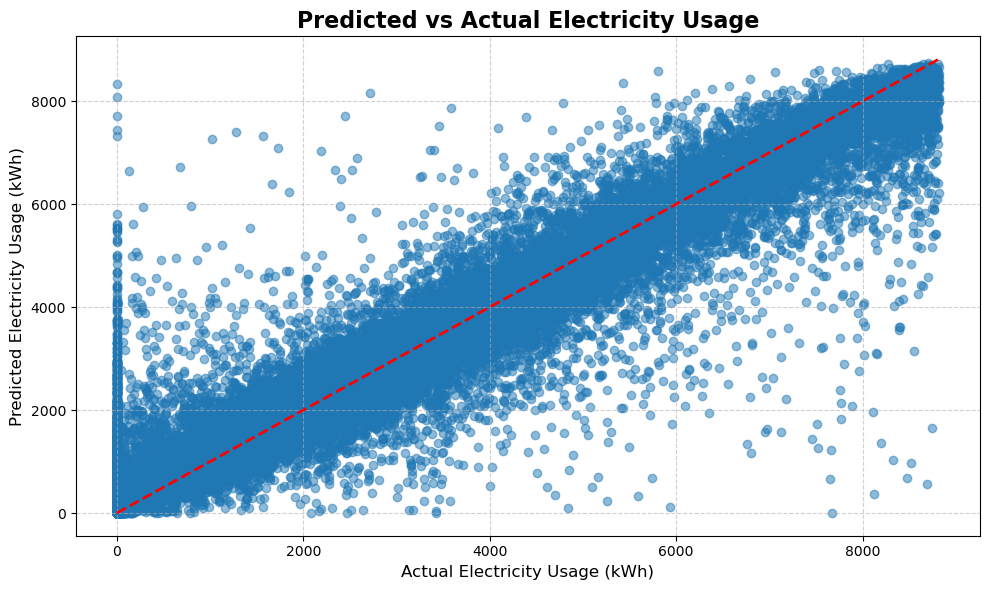

In [42]:
# Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)  # Reference line
plt.title('Predicted vs Actual Electricity Usage', fontsize=16, fontweight='bold')
plt.xlabel('Actual Electricity Usage (kWh)', fontsize=12)
plt.ylabel('Predicted Electricity Usage (kWh)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()